In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
import xgboost as xgb
from sklearn import metrics, preprocessing
from sklearn.inspection import permutation_importance, plot_partial_dependence
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

mpl.rcParams["figure.dpi"] = 150

import warnings
warnings.filterwarnings("ignore")
plt.ioff()
# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## load the data - this dataset must NOT be changed
s_mobile = pd.read_pickle("data/s_mobile.pkl")
s_mobile["churn_yes"] = (s_mobile["churn"] == "yes").astype(int)

### XGBoost

In [3]:
X = pd.get_dummies(s_mobile.loc[:, "changer":"occupation"], drop_first=True)
y = s_mobile.churn_yes

In [4]:
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=100,
    objective="binary:logistic",
    use_label_encoder=False,
    scale_pos_weight=1 / 49,
    eval_metric="auc",
    random_state=1234,
).fit(X[s_mobile.training == 1], y[s_mobile.training == 1], verbose=True)

Commenting out CV below since this was not the model that yielded the best results/predictions anyways, and to speed up processing time and Git pipelines.

In [5]:
from sklearn.model_selection import GridSearchCV
param_grid = {
"n_estimators": [50, 100, 150],
"scale_pos_weight":[1/49],
'use_label_encoder':[False],
"max_depth": [2,4],
'random_state':[1234],
}
scoring = {"AUC": "roc_auc"}
# clf_cv = GridSearchCV(
# clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=True
# ).fit(X[s_mobile.training == 1], y[s_mobile.training == 1])

In [6]:
act_pred = (600 / 29400)
#lr_pred = (lr.predict(s_mobile[s_mobile.representative == 1]).mean().round(5))
clf_pred = (clf.predict_proba(X[s_mobile.representative == 1])[:, 1].mean().round(5))
#cv_pred = (clf_cv.predict_proba(X[s_mobile.representative == 1])[:, 1].mean().round(5))

In [7]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

In [8]:
clf_imp = importance(clf, X[s_mobile.training == 1], y[s_mobile.training == 1], X.columns)
#cv_imp = importance(clf_cv, X[s_mobile.training == 1], y[s_mobile.training == 1], X.columns)

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))
features=[4,12]
ax.set_title("Partial Dependence Plots")
fig = plot_partial_dependence(
    clf,
    X[s_mobile.training == 1], features,
    ax=ax,
)

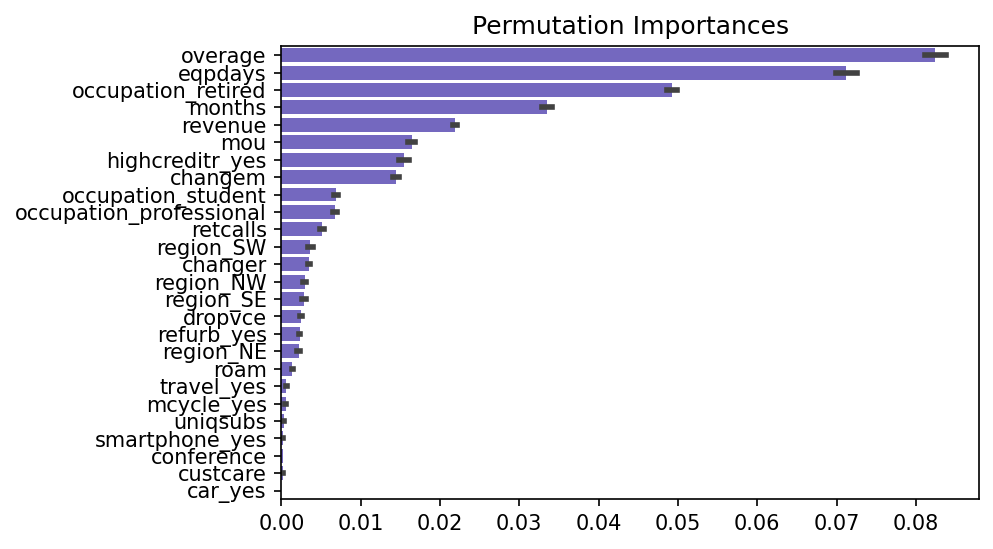

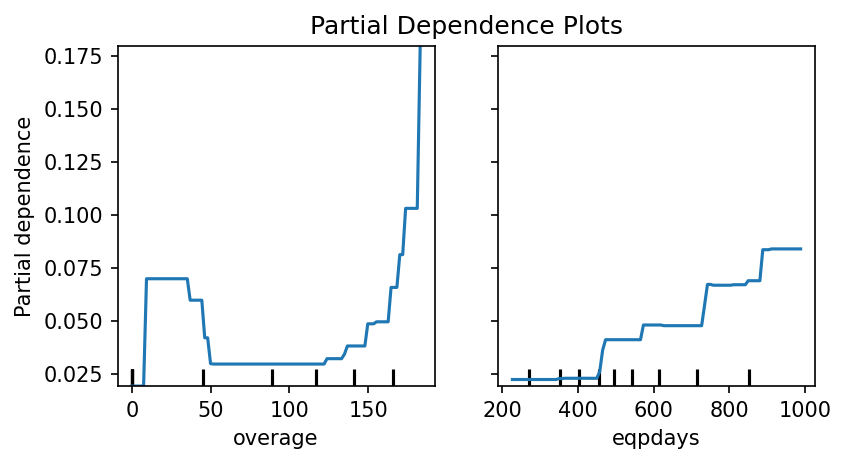

In [10]:
plt.show(clf_imp)

### Alternate Model: Tuned Logistic Regression for Non-Linearity

In [13]:
# add case weights
class_weight_dict = {0: 49, 1: 1}
s_mobile["churn_yes"] = (s_mobile["churn"] == "yes").astype(int)
s_mobile["cweight"] = rsm.ifelse(
    s_mobile.churn == "yes", class_weight_dict[1], class_weight_dict[0]
)

In [14]:
Xs = rsm.scale_df(
    s_mobile.loc[:, "changer":"occupation"],
    wt=s_mobile.cweight,
    train=s_mobile.training == 1,
)
Xs["churn_yes"] = s_mobile.churn_yes

In [15]:
Xs['ov_2'] = Xs['overage'] ** 2
Xs['ov_cubed'] = Xs['overage'] * Xs['overage'] * Xs['overage']

s_mobile['ov_cubed'] = s_mobile['overage'] * s_mobile['overage'] * s_mobile['overage']

form_tune = 'churn_yes ~ refurb + smartphone + highcreditr + mcycle + car + travel + region + occupation + changer + changem\
+ revenue + mou + overage + roam + conference + months + uniqsubs + custcare + retcalls + dropvce + eqpdays + ov_2 + ov_cubed'


# lr_tune_mod = smf.glm(
#     formula=form_tune,
#     family=Binomial(link=logit()),
#     freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
#     data=s_mobile[s_mobile.training == 1],
# )
# lr_tune = lr_tune_mod.fit(cov_type="HC1")

lr_tune_std = smf.glm(
    formula=form_tune,
    family=Binomial(link=logit()),
    freq_weights=s_mobile.loc[s_mobile.training == 1, "cweight"],
    data=Xs[s_mobile.training == 1],
).fit(cov_type="HC1")
#rsm.or_ci(lr_tune)

importances_alt = (
    rsm.or_ci(lr_tune_std, importance=True, data=Xs[s_mobile.training == 1])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)